In [1]:
import pystare
import pystareplotlib
import pystareplotlib.pystareplotlib as psplot
from pystareplotlib.pystareplotlib import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.geodesic import Geodesic

import numpy
import math
from math import sqrt,sin,cos

import pyproj
import scipy.linalg
from scipy.linalg import expm, norm

import geopandas
import starepandas

In [2]:
import h5py

In [3]:
# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
# PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
#matplotlib notebook
%matplotlib inline

usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']

#mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
#mpl.rcParams['legend.fontsize'] = 6

mpl.rcParams['figure.dpi'] = 2 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['figure.figsize'] = [3, 3]

print('Current DPI: ',mpl.rcParamsDefault['figure.dpi'])

Current DPI:  100.0


In [4]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=-179.9
                             ,central_latitude=-89.9
                             ,satellite_height=35785831
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}

From [The IMERG multi-satellite precipitation estimates reformatted as 2-byte GeoTIFF files
for display in a Geographic Information System](https://gpm.nasa.gov/sites/default/files/2020-06/IMERG-GIS-Readme_4_22_20.pdf).

Both the HDF5 and GIS versions of IMERG contain rectangular latitude-longitude grids that have 3600 columns for longitude and 1800 rows for latitude. This grid covers the globe (90°S to 90°N and 180°W to 180°E) at 0.1° resolution.

In [5]:
def mp(l):
    return list(l)+[l[0]]

In [98]:
class grid:
    def __init__(self,x,y,nx_intervals,ny_intervals,name=''):
        self.x = x
        self.y = y
        self.nx_intervals = nx_intervals
        self.ny_intervals = ny_intervals
        self.Lx=x[1]-x[0]
        self.Ly=y[1]-y[0]
        self.dx=self.Lx/nx_intervals
        self.dy=self.Ly/ny_intervals
        self.name = name
    def corners(self,i,j):
        dx = self.dx
        dy = self.dy
        x0 = self.x[0]
        y0 = self.y[0]
        corners = []
        x = x0 + i*dx; y = y0 + j*dy
        corners = corners + [(x,y)]
        x = x0 + (i+1)*dx; y = y0 + j*dy
        corners = corners + [(x,y)]
        x = x0 + (i+1)*dx; y = y0 + (j+1)*dy
        corners = corners + [(x,y)]
        x = x0 + i*dx; y = y0 + (j+1)*dy
        corners = corners + [(x,y)]
        return corners
#        return [(i*dx,j*dy),((i+1)*dx,j*dy),((i+1)*dx,(j+1)*dy),((i)*dx,(j+1)*dy)]
    def corners2(self,i,j):
        return zip(*self.corners(i,j))
    def centroid(self,i,j):
        corners2 = list(self.corners2(i,j))
#        print(corners2)
#        print(list(corners2[0]))
        lon = sum(list(corners2[0]))/4.0
        lat = sum(list(corners2[1]))/4.0
        return lon,lat
    def sivs(self,i,j,level=None):
        lonlats = list(self.corners2(i,j))
        lons = lonlats[0]
        lats = lonlats[1]
        lon_,lat_=self.centroid(i,j)
#        print(lons,lats,lon_,lat_)

        center = pystare.from_latlon([lat_],[lon_],27)
        corners = pystare.from_latlon(lats,lons,27)
#        print('corners: ',corners)
        corners = pystare.adapt_resolution_to_proximity([corners[0],corners[2]])
#        print('corners: ',corners)
        corner_level = corners[0] & 31
        center[0] = (center[0] & ~31) + corner_level
#        center[0] = (center[0] & ~31) + (corner_level - 1)
    
#        print('cl: ',corner_level+1)

#        print('level: ',level,type(level))
        if level is None:
            cover = pystare.cover_from_ring(lats,lons,level=int(corner_level + 4))
        else:
            cover = pystare.cover_from_ring(lats,lons,level=int(level))
        
        return \
            [cover,lons,lats]\
            ,[center,[lon_],[lat_]]
    def to_h5(self,filename,level=None):
        f = h5py.File(filename,'w')
        info = f.create_group('info')
        info.create_dataset('name',data = filename)
        info.create_dataset('nx_intervals',data = self.nx_intervals)
        info.create_dataset('ny_intervals',data = self.ny_intervals)

        cells = f.create_group('cells')
        index = f.create_group('stare_index')
        for j in range(self.ny_intervals):
            for i in range(self.nx_intervals):
                sivs,centroid = self.sivs(i,j,level)
                
                if level is None:
                    level = (centroid[0][0] & 31) + 4
                
                l = i + self.nx_intervals*j

                jgroup = cells.create_group(str(i)+'/'+str(j))
                
                jgroup.create_dataset('i',data   = i)
                jgroup.create_dataset('j',data   = j)
                jgroup.create_dataset('ij',data  = l)
                
                jgroup.create_dataset('ncorners',data = len(sivs[1]))
                jgroup.create_dataset('level',   data = level)
                
                jgroup.create_dataset('lons',data  = sivs[1])
                jgroup.create_dataset('lats',data  = sivs[2])
                jgroup.create_dataset('lon_centroid',data  = centroid[1][0])
                jgroup.create_dataset('lat_centroid',data  = centroid[2][0])
                
                jgroup.create_dataset('sivs',data  = sivs[0])
                jgroup.create_dataset('sidx',data  = centroid[0][0])
                
                c_level = centroid[0][0] & 31
                
                for s in sivs[0]:
                    s_c_level = pystare.spatial_clear_to_resolution(
                        pystare.spatial_coerce_resolution(s,c_level))
                    # bug hidx0 = hex(s_c_level)
                    hidx0 = '0x{n:016x}'.format(n=s_c_level)
                    # hidx  = hex((s_c_level & ~31)/2)
                    hidx = hidx0[0:4]+'/'+hidx0[4:6]+'/'+hidx0[6:8]+'/'+hidx0[8:10]+'/'+hidx0[10:12]+'/'+hidx0[12:]
                    try:
                        s_c_group = index.create_group(hidx)
                    except ValueError:
                        s_c_group = index[hidx]
                    try:
                        s_c_ij_group = s_c_group.create_group(str(i)+'/'+str(j))
                        s_c_ij_group.create_dataset('i', data = i)
                        s_c_ij_group.create_dataset('j', data = j)
                    except ValueError:
                        pass
                
        f.close()
        return True
                
                

In [97]:
'0x{n:016x}'.format(n=12)

'0x000000000000000c'

In [ ]:
g10 = grid((0,1),(0,1),10,10)

In [ ]:
g10.to_h5('g10.h5',9)

In [ ]:
!open g10.h5

In [ ]:
!rm g10.h5

In [ ]:
hex(4430990060083997897)

In [ ]:
list(map(hex,[4431031859937280009, 4431036257983791113, 4431038457007046665]))

In [ ]:
sivs,centroid=g10.sivs(0,6,9)
sivs,centroid,list(map(hex,sivs[0]))

In [ ]:
s1 = int(4431101784210725450)
for r in [11,10,9,8,7,6,5,4,3,2,1,0]:
    s = pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(s1,r))
    print(
#        r,'\n'
#         ,hex(int((s & ~31))),'\n'
         hex(int((s & ~31)/2))
    )

In [ ]:
sivs,centroid

In [ ]:
centroid[0][0] & 31

In [ ]:
g10.corners(0,0)

In [ ]:
g10.centroid(0,0)

In [ ]:
g20 = grid((0,1),(0,1),20,20)

In [100]:
gImerg = grid((-180,180),(-90,90),3600,1800)

In [ ]:
gImerg.corners(0,0)

In [ ]:
# i=1800; j=900
# i=50; j=50
# i=5; j = 5
i=0; j = 1

lonlats = list(gImerg.corners2(i,j))
lons = lonlats[0]
lats = lonlats[1]
lon_,lat_=gImerg.centroid(i,j)

In [101]:
gImerg = grid((-180,180),(-90,90),3600,1800)

In [102]:
gImerg.to_h5('imerg.h5')

True

In [99]:
! rm imerg.h5

rm: imerg.h5: No such file or directory


In [ ]:
gr = gImerg

In [ ]:
gr = g10

In [76]:
# i=1800; j=900
# i=500; j=500
i=500; j=100
# i=50; j=50
# i=5; j = 5
# i=0; j = 1

level = 13

# sivs,centroid = gr.sivs(i,j,level)
sivs,centroid = gr.sivs(i,j)

lons = sivs[1]
lats = sivs[2]
lon_ = centroid[1][0]
lat_ = centroid[2][0]
sivs = sivs[0]

NameError: name 'gr' is not defined

In [114]:
f.close()

In [103]:
f = h5py.File('imerg.h5','r')

cells = f.get('cells')

In [104]:
ij = '1800/900/'
ij = '900/900/'
ij = '900/100/'

sivs = cells[ij+'sivs'][:]

lons = cells[ij+'lons'][:]
lats = cells[ij+'lats'][:]
lon_ = cells[ij+'lon_centroid'][()]
lat_ = cells[ij+'lat_centroid'][()]

sidx = [cells[ij+'sidx'][()]]




In [105]:
index = f.get('stare_index')

In [106]:
index['0x10/00/00/00/00/'].keys()

<KeysViewHDF5 ['000009']>

In [113]:
index['0x10/00/00/00/00/000009'].keys()

<KeysViewHDF5 ['96', '97', '98', '99']>

In [107]:
for i in (sivs,lons,lats,lon_,lat_,sidx):
    print(i)

[2301680294698156046 2301680296845639694 2301680298993123342
 2301680301140606990 2301680303288090638 2301680305435574286
 2301680307583057934 2301680311878025230 2301680314025508878
 2301680316172992526 2301680318320476174 2301680320467959822
 2301680322615443470 2301680324762927118 2301680344090279950
 2301680361270149134 2301680543806259214 2301680550248710158
 2301680552396193806 2301680554543677454 2301680556691161102
 2301680558838644750 2301680560986128398 2301680565281095694
 2301680576018513934 2301680578165997582 2301680580313481230
 2301680582460964878 2301680610378252302 2301680612525735950
 2301680616820703246 2301680618968186894 2301680623263154190
 2301680625410637838 2301680627558121486 2301680636148056078
 2301680638295539726 2301680640443023374 2301680642590507022
 2301680644737990670 2301680646885474318 2301680649032957966
 2301680651180441614 2301680655475408910 2301680657622892558
 2301680659770376206 2301680661917859854 2301680664065343502
 2301680666212827150 230

In [108]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=lon_
                             ,central_latitude=lat_
#                             ,satellite_height=35785831
                             ,satellite_height= 3000000
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}

In [109]:
hex(centroid[0][0])

NameError: name 'centroid' is not defined

In [ ]:
hex(pystare.spatial_clear_to_resolution(centroid[0][0]))

In [110]:
sidx

[2301680798294543434]

100
200
300


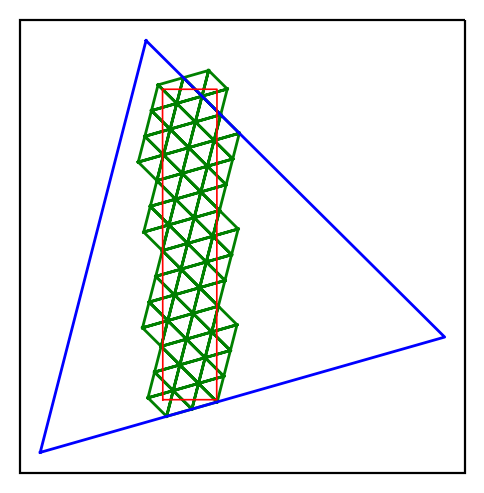

In [111]:
print('100')
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=False
    ,plot_options=nearside_plot_options
#    ,plot_options=usr_plot_options
#    ,set_global=True
    ,set_global=False
    ,show_fig=False
    ,color='g'
)

# sidx = centroid[0]

if True:
    print('200')
    figax,sivs_cache_2,sivs_triang_2 = hello_plot(
        figax=figax
        ,spatial_index_values=sidx
    #    ,spatial_index_values = sivs
        ,plot_options=nearside_plot_options
    #    ,plot_options=usr_plot_options
    #    ,set_global=True
        ,show_fig=False
        ,color='b')

if True:
    print('300')
    color='r'
    ls='-'
    lw=1
    figax.ax.plot(mp(lons),mp(lats)
                    ,transform=nearside_plot_options['transform']
                    ,color=color
                    ,linestyle=ls
                    ,lw=lw*0.6)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax